## **IMPORT DATA AND PRE-PROCESSING**

In [ ]:
import pandas as pd
#Twitter15 = pd.read_csv('Twitter15.csv',delimiter='\t')
#Twitter16 = pd.read_csv('Twitter16.csv',delimiter='\t')

In [ ]:
Twitter15.head()

,tweet,label
0,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified
1,an open letter to trump voters from his top st...,unverified
2,america is a nation of second chances —@potus ...,non-rumor
3,"brandon marshall visits and offers advice, sup...",non-rumor
4,rip elly may clampett: so sad to learn #beverl...,true


In [ ]:
Twitter16.head()

,tweet,label
0,correct predictions in back to the future ii URL,false
1,.@whitehouse in rainbow colors for #scotusmarr...,true
2,cops bought the alleged church shooter burger ...,false
3,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified
4,an open letter to trump voters from his top st...,unverified


In [ ]:
Twitter15['label'].value_counts(normalize=True) * 100

non-rumor     25.100671
unverified    25.100671
true          24.966443
false         24.832215
Name: label, dtype: float64

In [ ]:
Twitter16['label'].value_counts(normalize=True) * 100

true          25.305623
non-rumor     25.061125
false         25.061125
unverified    24.572127
Name: label, dtype: float64

In [ ]:
!pip install emot

In [ ]:
#To convert emojis and emoticons to words
from emot.emo_unicode import UNICODE_EMO
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

In [ ]:
def puntuation_removal(tweets):
  #punctuation removal and converting to lowercase
  punct = '''!()-[]{};:'\,<>/=?"“”@#$%^&*_~�—.'''   
  punct_removed=""
  for sentence in tweets:
    for letter in sentence:
      if letter not in punct:
        punct_removed= punct_removed + letter
  return punct_removed

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Remove stopwords
def stopwords_removal(tweets):
  stop_words = stopwords.words('english')
  filtered =[]
  for word in tweets.split():
    if word not in stop_words:
      word = word.lower()
      filtered.append(word)
  return ' '.join(filtered)

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Lemmatize to convert words to there root form
def lemmatize(tweets):
  lemmatizer=WordNetLemmatizer()
  filtered =[]
  for each_word in tweets.split():
    filtered.append(lemmatizer.lemmatize(each_word))
  return ' '.join(filtered)

In [ ]:
#Remove URL from tweets
import re
def remove_url(tweets):
  patt = re.compile('(\s*)URL(\s*)')
  tweets = patt.sub(' ',tweets)
  return tweets

In [ ]:
#Preprocessing
def preprocessing(tweets):
  tweets = puntuation_removal(tweets)
  tweets = stopwords_removal(tweets)
  tweets = lemmatize(tweets)
  return tweets

In [ ]:
preprocessing("I am an employee of Oracle Corporation. Views expressed here are my own and not necessarily those of my employer.")

'i employee oracle corporation view expressed necessarily employer'

In [ ]:
for i in range(len(Twitter15['tweet'])-1):
  Twitter15['tweet'][i] = preprocessing(Twitter15['tweet'][i])

for i in range(len(Twitter16['tweet'])-1):
  Twitter16['tweet'][i] = preprocessing(Twitter16['tweet'][i])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Twitter15['label'] = le.fit_transform(Twitter15['label'])
Twitter16['label'] = le.fit_transform(Twitter16['label'])

## **LSTM WITH PRE-TRAINED GLOVE EMBEDDING**

In [ ]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-04-29 16:16:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-29 16:16:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-29 16:16:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
def model_input(X_train, X_test,MAX_NB_WORDS=65000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    print(text.shape)

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    
    indices = np.arange(text.shape[0])
    text = text[indices]
    print(text.shape)

    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]

    embeddings_dict = {}
    f = open("glove.6B.100d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()

    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [ ]:
def build_lstm(word_index, embeddings_dict, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=100, dropout=0.5):
    # Initializing a sequential model
    model = Sequential()
    # Using embedding_dict to make the embedding matrix
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("EMBEDDING_DIM is not equal to embedding_vector file GloVe")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    #embedding layer
    model.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(nclasses, activation='softmax')) #Softmax activation since multi-class classification
    opt=Adam(learning_rate=5e-5)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

### Twitter15 Dataset with 70:30 split for train and test

In [ ]:
from sklearn.model_selection import train_test_split
X = Twitter15.tweet
y = Twitter15.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train_Glove, X_test_Glove, word_index, embeddings_dict = model_input(X_train,X_test)
model = build_lstm(word_index, embeddings_dict, 4)
model.summary()

(1490,)
Found 4700 unique tokens.
(1490, 500)
Total 400000 word vectors.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 100)          470100    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 500, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_58 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_59 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_60 (Dense)             (None, 100)             

In [ ]:
history1 = model.fit(X_train_Glove, y_train,epochs=30,validation_data=(X_test_Glove,y_test),batch_size=128,verbose=1)

Epoch 1/30
9/9 [==============================] - 17s 2s/step - loss: 1.3882 - accuracy: 0.2416 - val_loss: 1.3787 - val_accuracy: 0.3043
Epoch 2/30
9/9 [==============================] - 15s 2s/step - loss: 1.3731 - accuracy: 0.3317 - val_loss: 1.3583 - val_accuracy: 0.3177
Epoch 3/30
9/9 [==============================] - 15s 2s/step - loss: 1.3432 - accuracy: 0.3616 - val_loss: 1.3051 - val_accuracy: 0.4004
Epoch 4/30
9/9 [==============================] - 15s 2s/step - loss: 1.2791 - accuracy: 0.4352 - val_loss: 1.2848 - val_accuracy: 0.3960
Epoch 5/30
9/9 [==============================] - 15s 2s/step - loss: 1.2104 - accuracy: 0.4629 - val_loss: 1.1754 - val_accuracy: 0.4541
Epoch 6/30
9/9 [==============================] - 15s 2s/step - loss: 1.0590 - accuracy: 0.5882 - val_loss: 1.1692 - val_accuracy: 0.4698
Epoch 7/30
9/9 [==============================] - 15s 2s/step - loss: 1.0081 - accuracy: 0.5769 - val_loss: 1.1172 - val_accuracy: 0.5190
Epoch 8/30
9/9 [==================

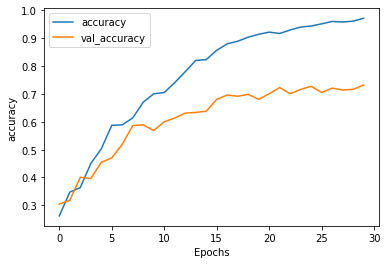

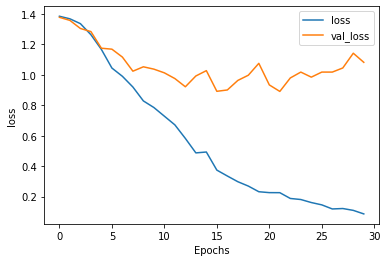

In [ ]:
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

In [ ]:
print("\n Evaluating Model \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))


 Evaluating Model ... 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.67      0.73       108
           1       0.66      0.74      0.70       119
           2       0.78      0.80      0.79       103
           3       0.72      0.73      0.72       117

    accuracy                           0.73       447
   macro avg       0.74      0.73      0.73       447
weighted avg       0.74      0.73      0.73       447



### Twitter16 Dataset with 70:30 Split for train and test

In [ ]:
from sklearn.model_selection import train_test_split
X = Twitter16.tweet
y = Twitter16.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train_Glove, X_test_Glove, word_index, embeddings_dict = model_input(X_train,X_test)
model = build_lstm(word_index, embeddings_dict, 4)
model.summary()

(818,)
Found 3004 unique tokens.
(818, 500)
Total 400000 word vectors.


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 100)          300500    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 500, 100)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_64 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_65 (Dense)             (None, 100)             

In [ ]:
history2 = model.fit(X_train_Glove, y_train,epochs=30,validation_data=(X_test_Glove,y_test),batch_size=128,verbose=1)

Epoch 1/30
5/5 [==============================] - 11s 2s/step - loss: 1.3858 - accuracy: 0.2677 - val_loss: 1.3852 - val_accuracy: 0.2480
Epoch 2/30
5/5 [==============================] - 8s 2s/step - loss: 1.3697 - accuracy: 0.3310 - val_loss: 1.3724 - val_accuracy: 0.2886
Epoch 3/30
5/5 [==============================] - 8s 2s/step - loss: 1.3502 - accuracy: 0.3762 - val_loss: 1.3303 - val_accuracy: 0.3943
Epoch 4/30
5/5 [==============================] - 8s 2s/step - loss: 1.3023 - accuracy: 0.4713 - val_loss: 1.2741 - val_accuracy: 0.3902
Epoch 5/30
5/5 [==============================] - 8s 2s/step - loss: 1.2355 - accuracy: 0.4714 - val_loss: 1.1687 - val_accuracy: 0.4715
Epoch 6/30
5/5 [==============================] - 8s 2s/step - loss: 1.1358 - accuracy: 0.5204 - val_loss: 1.0788 - val_accuracy: 0.4797
Epoch 7/30
5/5 [==============================] - 8s 2s/step - loss: 1.0647 - accuracy: 0.5432 - val_loss: 1.1152 - val_accuracy: 0.5610
Epoch 8/30
5/5 [========================

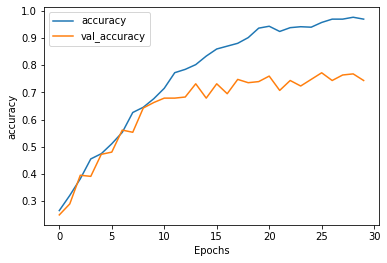

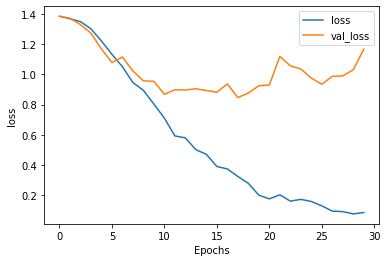

In [ ]:
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

In [ ]:
print("\n Evaluating Model \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))


 Evaluating Model ... 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.58      0.81      0.68        54
           1       0.70      0.56      0.63        55
           2       0.92      0.84      0.88        68
           3       0.80      0.74      0.77        69

    accuracy                           0.74       246
   macro avg       0.75      0.74      0.74       246
weighted avg       0.76      0.74      0.75       246



# **BERT PRE-TRAINED**
---



In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 17.2MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 
     |████████████████████████████████| 3.3MB 39.7MB/s 


In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Pre-trained BERT EMBEDDINGS
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
#Tokenization in BERT format
tokenized_15 = Twitter15['tweet'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_16 = Twitter16['tweet'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
#Padding
max_len = 0
for i in tokenized_15.values:
    if len(i) > max_len:
        max_len = len(i)

padded_15 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_15.values])
np.array(padded_15).shape

(1490, 41)

In [ ]:
#Padding
max_len = 0
for i in tokenized_16.values:
    if len(i) > max_len:
        max_len = len(i)

padded_16 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_16.values])
np.array(padded_16).shape

(818, 37)

In [ ]:
#Adding attention mask to Twitter15
attention_mask_15 = np.where(padded_15 != 0, 1, 0)
attention_mask_15.shape

(1490, 41)

In [ ]:
#Adding attention mask to Twitter16
attention_mask_16 = np.where(padded_16 != 0, 1, 0)
attention_mask_16.shape

(818, 37)

In [ ]:
#Getting vectors 
input_ids = torch.tensor(padded_15)  
attention_mask_15 = torch.tensor(attention_mask_15)

with torch.no_grad():
    last_hidden_states_15 = model(input_ids, attention_mask=attention_mask_15)

In [ ]:
#Getting vectors 
input_ids = torch.tensor(padded_16)  
attention_mask_16 = torch.tensor(attention_mask_16)

with torch.no_grad():
    last_hidden_states_16 = model(input_ids, attention_mask=attention_mask_16)

In [ ]:
features_15 = last_hidden_states_15[0][:,0,:].numpy()
labels_15 =   Twitter15['label']

features_16 = last_hidden_states_16[0][:,0,:].numpy()
labels_16 =   Twitter16['label']

**SVM**

In [ ]:
#train, test split
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features_16, labels_16, test_size=0.2,random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV
param={'kernel':('rbf', 'sigmoid'),
      'C':np.arange(1,42,10),
      'degree':np.arange(3,6)}

NameError: ignored

In [ ]:
SVModel = SVC()
GridS = GridSearchCV(SVModel,param,cv=5)
GridS.fit(train_features,train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1, 11, 21, 31, 41]),
                         'coef0': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00]),
                         'degree': array([3, 4, 5]),
                         'kernel': ('rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
SVM = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale',coef0=0.0)
SVM.fit(train_features,train_labels)# predict the labels on validation dataset
predictions_SVM = SVM.predict(test_features)

In [ ]:
 #Use accuracy_score function to get the accuracy
from sklearn.metrics import accuracy_score
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM,test_labels)*100)

SVM Accuracy Score ->  58.536585365853654


**RANDOM_FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_features,train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

In [ ]:
rfc1.fit(train_features,train_labels)
pred=rfc1.predict(test_features)
print("Accuracy for Random Forest on CV data: ",accuracy_score(test_labels,pred))

Accuracy for Random Forest on CV data:  0.6219512195121951


# **FINE TUNED BERT**
---



In [ ]:
!pip install transformers

In [ ]:
from sklearn.model_selection import train_test_split
train_final , test_final = train_test_split(Twitter15, test_size=0.2,random_state=0)

In [ ]:
train_final = train_final.reset_index()
test_final = test_final.reset_index()

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Get the lists of sentences and their labels.
sentences = train_final['tweet']
labels = train_final['label']

# Load the BERT tokenizer.
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,072 training samples
  120 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
#loading bert to classify sequence
model = BertForSequenceClassification.from_pretrained( "bert-large-uncased", num_labels = 4,output_attentions = False, output_hidden_states = False,)

#run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

optimizer = AdamW( model.parameters(), lr = 2e-5, eps = 1e-8)

from transformers import get_linear_schedule_with_warmup
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = total_steps)


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# Random seed
seed_val = 16

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
            
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:26.

  Average training loss: 1.33
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.51
  Validation Loss: 1.17
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:27.

  Average training loss: 0.96
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.85
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:28.

  Average training loss: 0.59
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.69
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     67.    Elapsed: 0:00:28.

  Average training loss: 0.37
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.67
  Validation took: 0:00:02

Training complete!
Total tr

In [ ]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.33,1.17,0.51,0:00:43,0:00:02
2,0.96,0.85,0.73,0:00:46,0:00:02
3,0.59,0.69,0.78,0:00:47,0:00:02
4,0.37,0.67,0.75,0:00:47,0:00:02


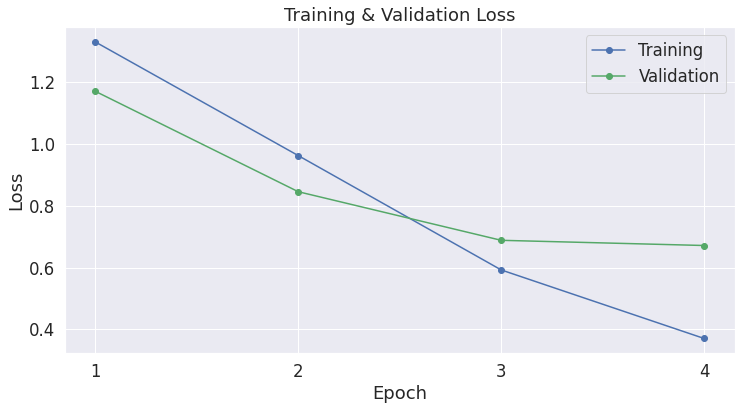

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Create sentence and label lists
sentences = test_final['tweet']
labels = test_final['label']

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size =  16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 298 test sentences...
    DONE.


In [ ]:
print(predictions)

[array([[ 1.5983374 ,  1.0699958 , -1.082781  , -0.7126124 ],
       [ 0.07137524, -0.5588703 ,  0.45862168,  0.4809673 ],
       [-0.5679131 , -1.4803356 ,  2.143618  ,  0.31761232],
       [-0.2211312 ,  0.87568647,  0.91505814, -1.1232944 ],
       [ 0.931524  ,  2.2428188 , -1.8212215 , -0.37696245],
       [-0.7378858 , -1.8818312 ,  1.1824362 ,  1.7041553 ],
       [ 0.04882753, -1.3381985 ,  2.535571  , -0.65847677],
       [-0.15524161,  2.5261004 , -0.48908672, -1.7770272 ],
       [ 1.3586969 ,  1.944399  , -0.91316324, -0.48138967],
       [ 0.3168776 , -1.8907923 , -1.0717524 ,  2.9818628 ],
       [ 0.47710186,  2.160873  , -0.35390183, -2.5301912 ],
       [-0.13523436, -1.3820765 ,  0.41297787,  1.8393742 ],
       [ 2.0971525 ,  1.3957366 , -0.83834916, -1.1367791 ],
       [ 1.9868746 ,  0.15846287, -0.25628877, -0.9232773 ],
       [ 2.7324846 , -0.02661885,  0.32024515, -1.1983716 ],
       [-0.85599655, -1.6198549 ,  1.7142524 ,  0.46988088]],
      dtype=float32), 

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels =[]
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)
  # Calculate and store the coef for this batch.  


Calculating Matthews Corr. Coef. for each batch...


In [ ]:
print(pred_labels)

[array([0, 3, 2, 2, 1, 3, 2, 1, 1, 3, 1, 3, 0, 0, 0, 2]), array([2, 2, 3, 3, 1, 2, 0, 0, 2, 1, 3, 2, 2, 3, 1, 1]), array([3, 0, 2, 2, 3, 3, 2, 0, 1, 2, 2, 0, 3, 2, 0, 0]), array([2, 3, 0, 2, 1, 0, 1, 1, 1, 2, 3, 2, 1, 1, 0, 3]), array([1, 3, 0, 1, 2, 2, 1, 0, 0, 3, 0, 3, 0, 1, 1, 0]), array([2, 2, 2, 2, 0, 0, 1, 3, 0, 2, 2, 3, 2, 2, 1, 1]), array([0, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1]), array([3, 1, 0, 1, 2, 1, 3, 2, 0, 2, 2, 3, 0, 1, 3, 3]), array([2, 3, 0, 2, 3, 3, 1, 0, 3, 2, 1, 2, 3, 0, 1, 0]), array([1, 2, 2, 1, 0, 0, 3, 2, 0, 3, 2, 1, 1, 0, 3, 0]), array([1, 2, 3, 1, 1, 0, 1, 0, 0, 3, 3, 3, 2, 1, 0, 0]), array([2, 3, 0, 3, 2, 3, 3, 3, 3, 1, 0, 1, 3, 2, 2, 1]), array([2, 3, 3, 2, 0, 1, 0, 1, 2, 0, 0, 0, 2, 2, 3, 3]), array([3, 1, 0, 1, 2, 0, 3, 0, 2, 0, 2, 0, 3, 1, 2, 3]), array([2, 3, 2, 0, 0, 3, 1, 2, 2, 2, 1, 3, 1, 2, 2, 2]), array([3, 3, 3, 0, 3, 0, 2, 3, 0, 3, 3, 2, 2, 2, 0, 3]), array([2, 3, 0, 3, 1, 0, 1, 3, 0, 1, 3, 0, 1, 1, 3, 0]), array([0, 1, 0, 1, 0, 3, 3, 0,

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(pred_labels, axis=0)
true_labels_all = np.concatenate(true_labels, axis=0)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_labels_all, flat_predictions)

0.6442953020134228